In [1]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import sklearn
from sklearn.datasets import make_regression as MR
from sklearn.linear_model import LinearRegression as LR, Lasso as LLR
from sklearn.model_selection import train_test_split, KFold, cross_val_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 

import torchvision
from torchvision import *
from torch.nn import *
from NN import NN, ClassificationReport

from PIL import Image, ImageDraw, ImageFont
from tqdm import tqdm
 
from sklearn import datasets
from random import shuffle

# Load the Data

In [2]:
data = pd.read_csv("E:/Thesis/data/assay.data.csv")
penalty = pd.read_csv("E:/Thesis/data/penalty.data.csv")

# in data first columns are Abbreviation, Toxicity, Cmax, EC10.CTB.PHH
# in penalty first columns are Abbreviation, EC10.CTB.PHH

X = data.iloc[:,3:] 
X[penalty.iloc[:,1:] == 1] = pd.NA
Y = data.loc[:,'Toxicity']

data_wm = pd.concat([Y,X], axis = 1)
data_wm.to_csv("E:/Thesis/data/assay_with_missing.csv")

In [3]:
data_wm

,Toxicity,EC10.CTB.PHH,EC20.CTB.PHH,EC50.CTB.PHH,EC10.CTB.HepG2,EC20.CTB.HepG2,EC50.CTB.HepG2,EC10.Nile.Red,EC20.Nile.Red,EC50.Nile.Red,...,EC50.CMFDA,ALOEC.Min,ALOEC.Med,ALEC.Min,ALEC.Q25,ALEC.Med,DEG1,DEG2,DEG5,SumLFC
0,1,NaN,NaN,NaN,0.239992,0.246046,0.281992,NaN,NaN,NaN,...,NaN,0.237000,0.750000,0.001058,0.356763,0.747817,0.237000,0.750000,0.750000,0.7500
1,1,NaN,NaN,NaN,0.033491,0.037591,0.045771,0.004540,0.009850,NaN,...,NaN,0.316000,0.316000,0.001217,0.183442,1.038170,0.316000,0.316000,NaN,NaN
2,1,0.068669,0.069132,NaN,0.003213,0.008060,0.027973,0.000785,0.001570,0.003946,...,NaN,0.004500,0.014200,0.000868,0.007123,0.012676,0.004500,0.004500,0.004500,0.0045
3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000500,0.001041,NaN,NaN,NaN,0.000500,0.000500,NaN,NaN
4,0,1.402745,2.152662,4.386666,1.575855,3.299099,10.009656,0.560132,1.205035,3.821514,...,NaN,0.040000,5.000000,0.251972,3.743257,4.580194,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,0.065967,0.078266,0.115496,0.030151,0.033985,0.044623,0.004750,0.009500,0.023751,...,NaN,0.000780,0.078000,0.000091,0.022357,0.029152,0.000780,0.007800,0.024700,0.0247
96,0,3.701232,4.526424,NaN,1.093706,1.498363,2.023467,2.871442,NaN,NaN,...,NaN,10.000000,10.000000,0.058639,2.947263,9.287147,10.000000,10.000000,10.000000,10.0000
97,1,10.134496,10.718386,12.797538,0.485637,1.361954,6.331279,0.399988,0.761241,1.713852,...,NaN,0.200000,5.000000,0.021074,1.012193,2.030883,1.000000,1.000000,1.000000,1.0000
98,0,0.096929,NaN,NaN,0.087745,0.156807,0.361907,0.113304,0.226609,NaN,...,NaN,0.015811,0.500000,0.072472,0.162960,0.195802,0.015811,0.050000,0.158114,0.5000


# Normalizing ( Cmax division) and Logarithmizing 

In [4]:
Cmax = data.iloc[:,2]
for col in X.columns:
    X[col] = np.log(X[col]/Cmax)

X.head(5)

data_nl = pd.concat([Y,X], axis = 1)
data_nl.to_csv("E:/Thesis/data/assay_with_missing&normalized&logarithmized.csv")

# Converting Each sample to Image

In [5]:
X[X.isna()] = '?'

X = X.to_numpy()
X[X != "?"] = X[X != "?"].astype(float).round(2)

Y = data.loc[:,'Toxicity'].to_numpy()

C:\Users\Dell\AppData\Local\Temp\ipykernel_1880\3299568563.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '?' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  X[X.isna()] = '?'


In [6]:
font_size=[8]*24
g_size = 25

grid=[(g_size*j, g_size*i) for i in range(1,6) for j in range(1,4) ]

grid = grid + [(g_size*j, grid[-1][1] + g_size) for j in range(1,3) ]

grid = grid + [(g_size*j, grid[-1][1] + g_size*i) for i in range(1,3) for j in range(1,4)]

grid = grid + [(g_size, grid[-1][1] + g_size)]

In [7]:
def sampletoimage(sample):
 img =  Image.fromarray(np.zeros((255,255)).astype('uint8'))
 draw = ImageDraw.Draw(img)    
 for f,s,g in zip(font_size,sample,grid):
  font = ImageFont.truetype("./font.ttf", size=f)
  draw.text(g,str(s),font=font, fill='white')

 return [np.array(img) for _ in range(3)]

In [8]:
X_img=np.array(list(map(sampletoimage,X)))

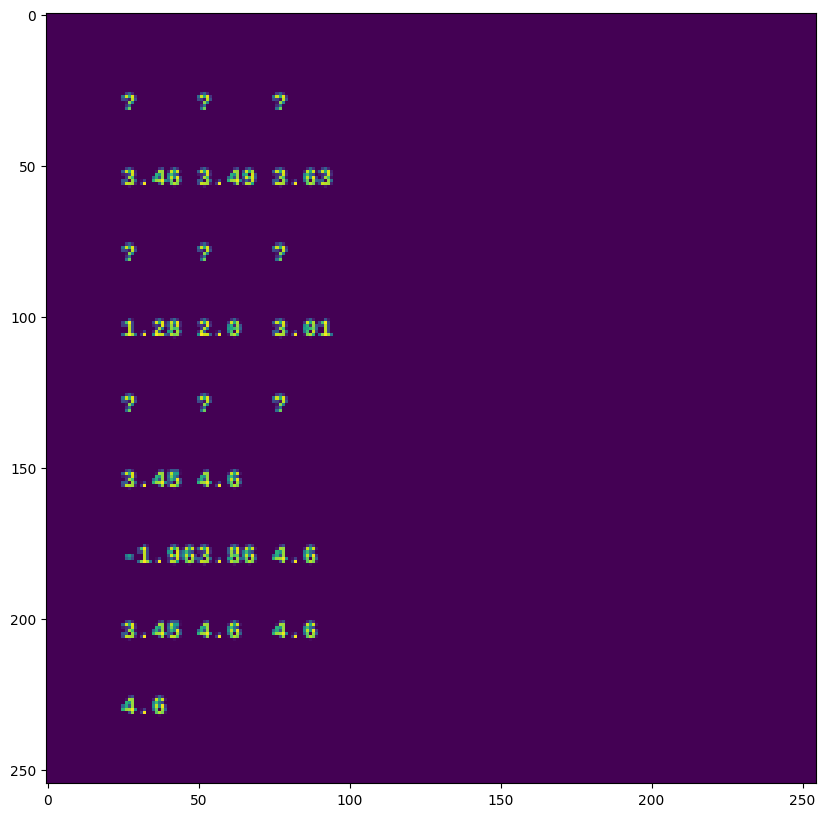

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(X_img[0,0])
#plt.savefig('E:/Thesis/29.01.2025/SuperTML(log&norm)')

In [10]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np

font_size = [12] * 24  # Slightly larger for readability in thesis figures
g_size = 30            # Larger grid cell to accommodate bigger font
canvas_size = (300, 500)  # Adjust canvas size as needed

# Recompute grid layout
grid = [(g_size * j, g_size * i) for i in range(1, 6) for j in range(1, 4)]
grid += [(g_size * j, grid[-1][1] + g_size) for j in range(1, 3)]
grid += [(g_size * j, grid[-1][1] + g_size * i) for i in range(1, 3) for j in range(1, 4)]
grid += [(g_size, grid[-1][1] + g_size)]

def sampletoimage(sample):
    img = Image.new('RGB', canvas_size, color='white')  # White background
    draw = ImageDraw.Draw(img)

    try:
        font_path = "./font.ttf"  # Or use DejaVuSans if font file missing
        for f, s, g in zip(font_size, sample, grid):
            font = ImageFont.truetype(font_path, size=f)
            # Get text size to center text
            text = str(s)
            text_w, text_h = draw.textsize(text, font=font)
            x = g[0] + (g_size - text_w) / 2
            y = g[1] + (g_size - text_h) / 2
            draw.text((x, y), text, font=font, fill='black')  # Dark text
    except IOError:
        # Fallback font
        font = ImageFont.load_default()
        for s, g in zip(sample, grid):
            draw.text(g, str(s), font=font, fill='black')

    return [np.array(img) for _ in range(3)]  # RGB channels identical

# Example of applying
X_img = np.array(list(map(sampletoimage, X)))


# Neural Network

In [11]:
device='cpu'
net = NN(model=models.resnet18(pretrained=True),
         cut=1,
         add=Sequential(Sequential(Linear(512,100),ReLU(),Linear(100,2)),Softmax(dim=1)),
         gradients=10)
net=net.to(device)

c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X_img, Y, test_size=0.2, random_state=50, shuffle=True, stratify = Y)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=5, shuffle=True, stratify = Y_train)

train_data = torch.utils.data.DataLoader(list(zip(X_train,Y_train)), batch_size=32, shuffle=True, drop_last=True,num_workers=2)
validation_data = torch.utils.data.DataLoader(list(zip(X_val,Y_val)),batch_size=1,num_workers=2) 

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

net.optimization(criterion,optimizer)
Train_stats, Test_stats = net.TRAIN(train_data,validation_data, 
                                    epochs=30, 
                                    batch_size=32,
                                    verbose=1,
                                    random_seed=1,
                                    device=device)

#net.save()

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x00000233D3D14B80>
Traceback (most recent call last):
  File "c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py", line 1568, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\multiprocessing\process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\multiprocessing\popen_spawn_win32.py", line 108, in wait
    res = _winapi.WaitForSingleObject(int(self._handle), msecs)
KeyboardInterrupt: 


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [32, 3, 500, 300, 3]

# Visualization

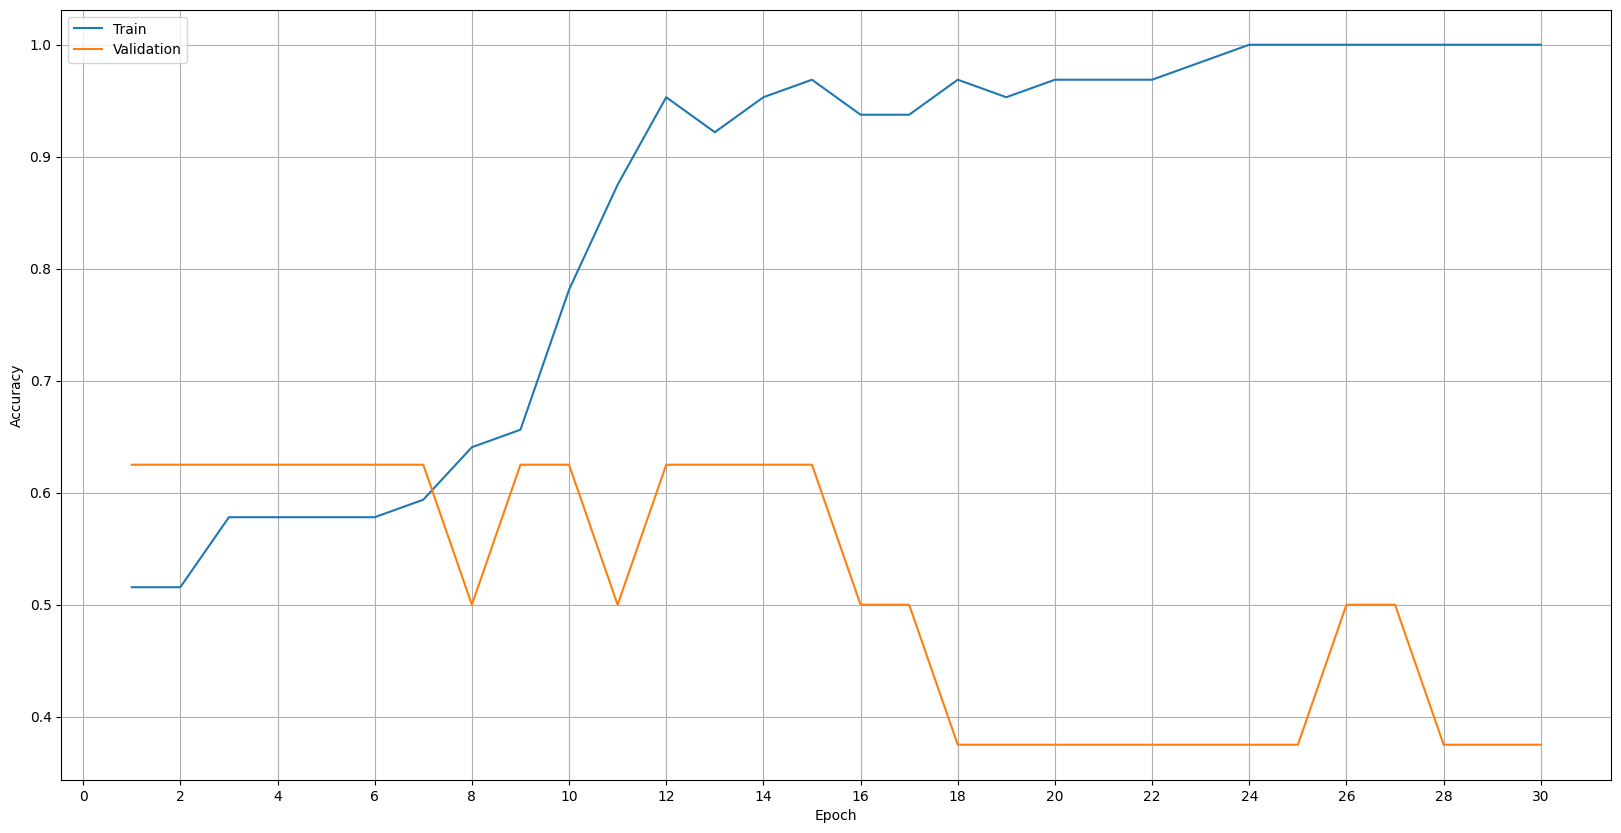

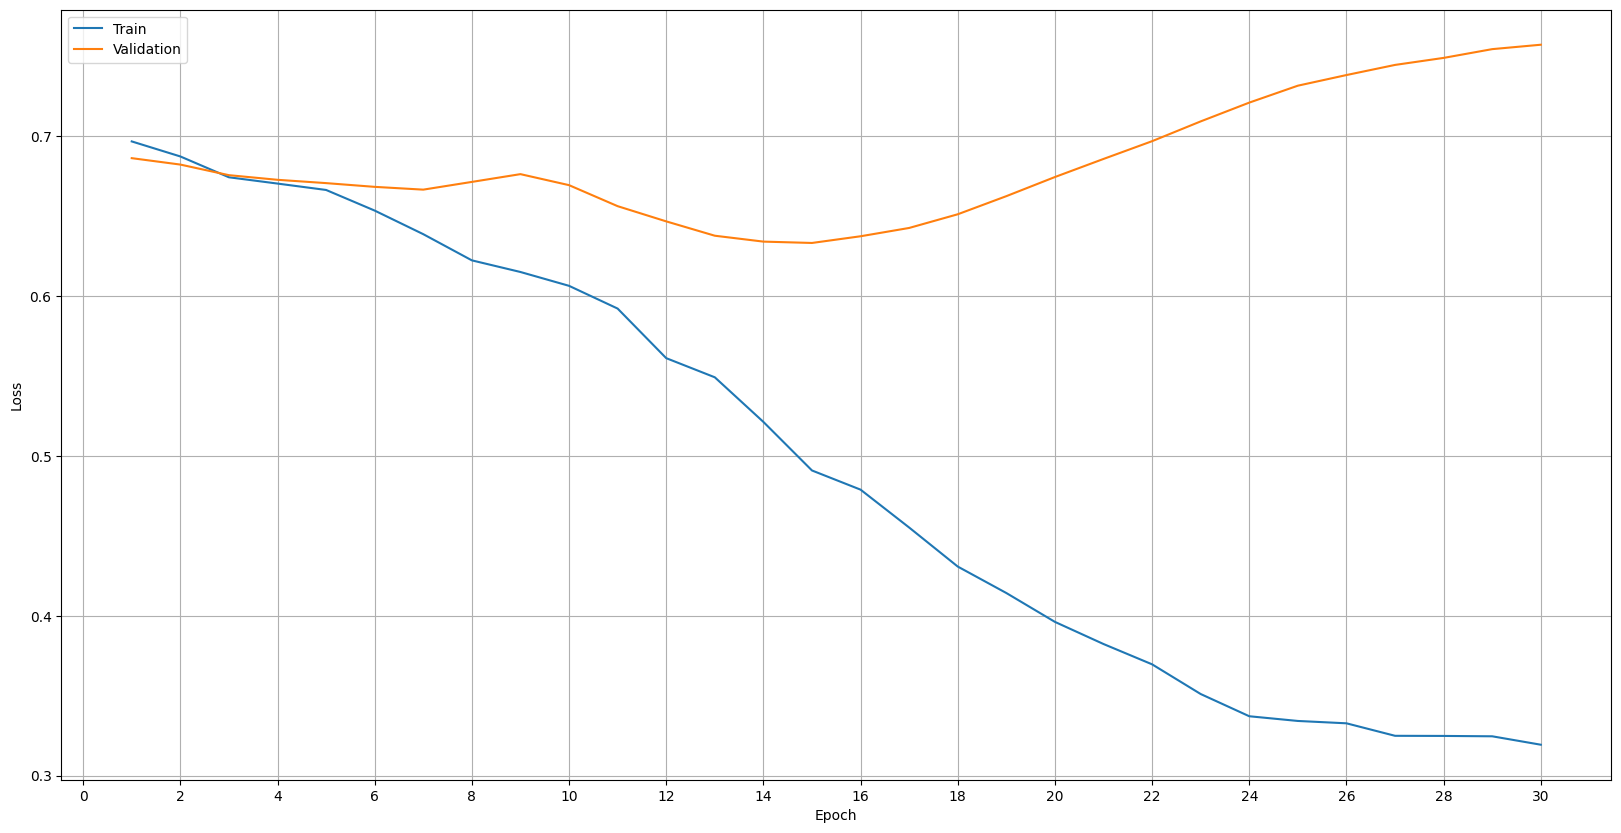

In [ ]:
net.plot('Accuracy')
net.plot('Loss')

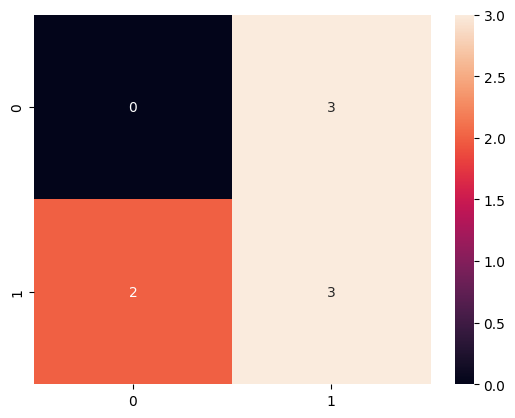

In [ ]:
report=ClassificationReport(net)
report.fit(X_val,Y_val)
report.heatmap()

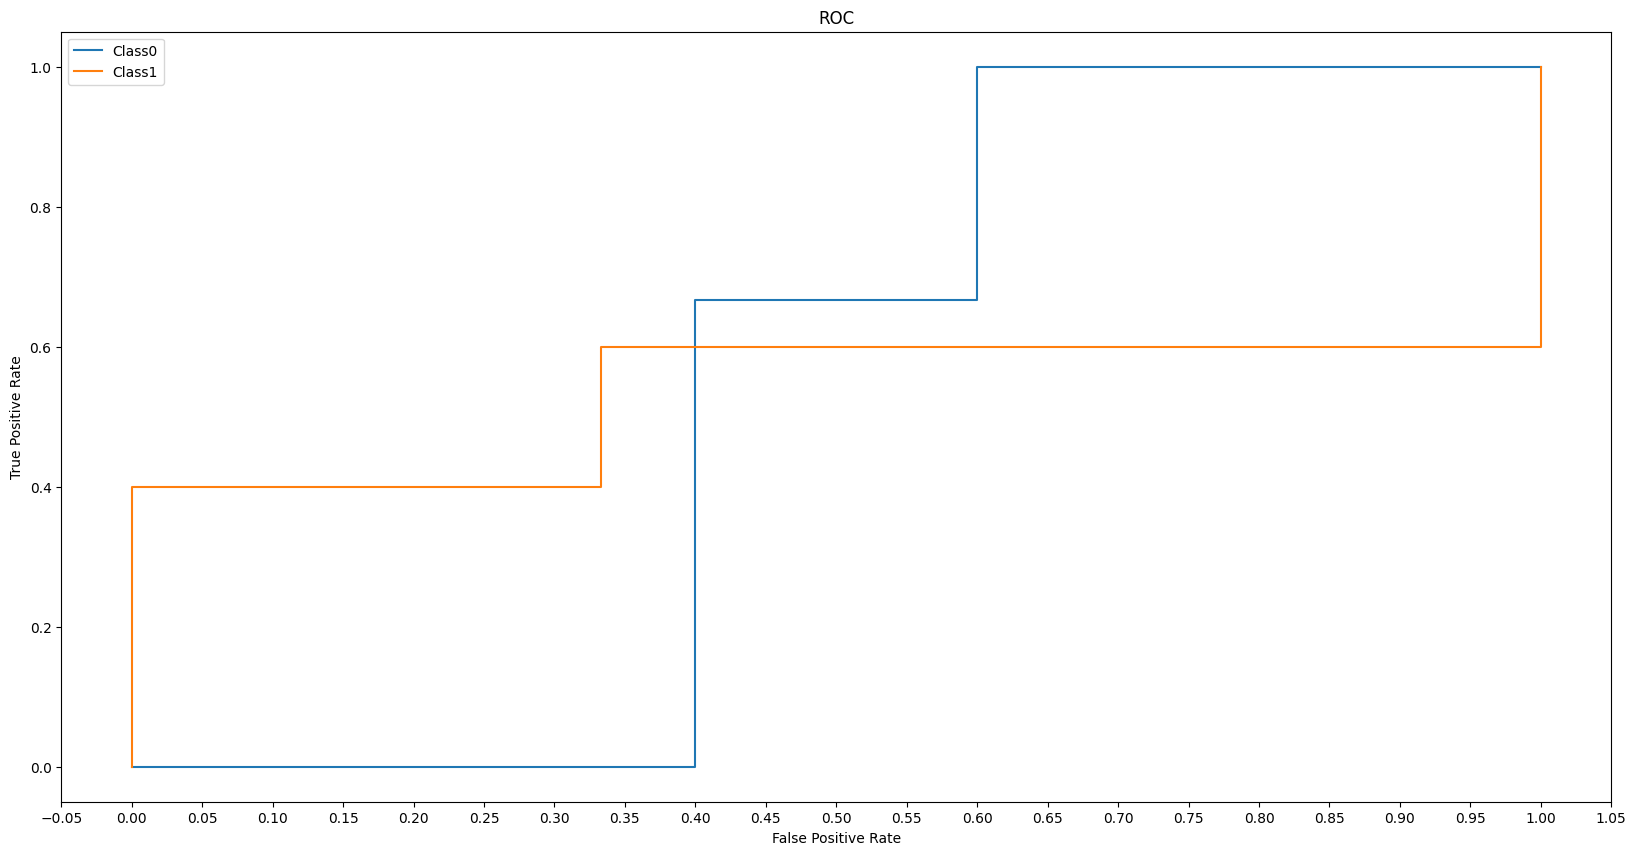

In [ ]:
report.plot_ROC()

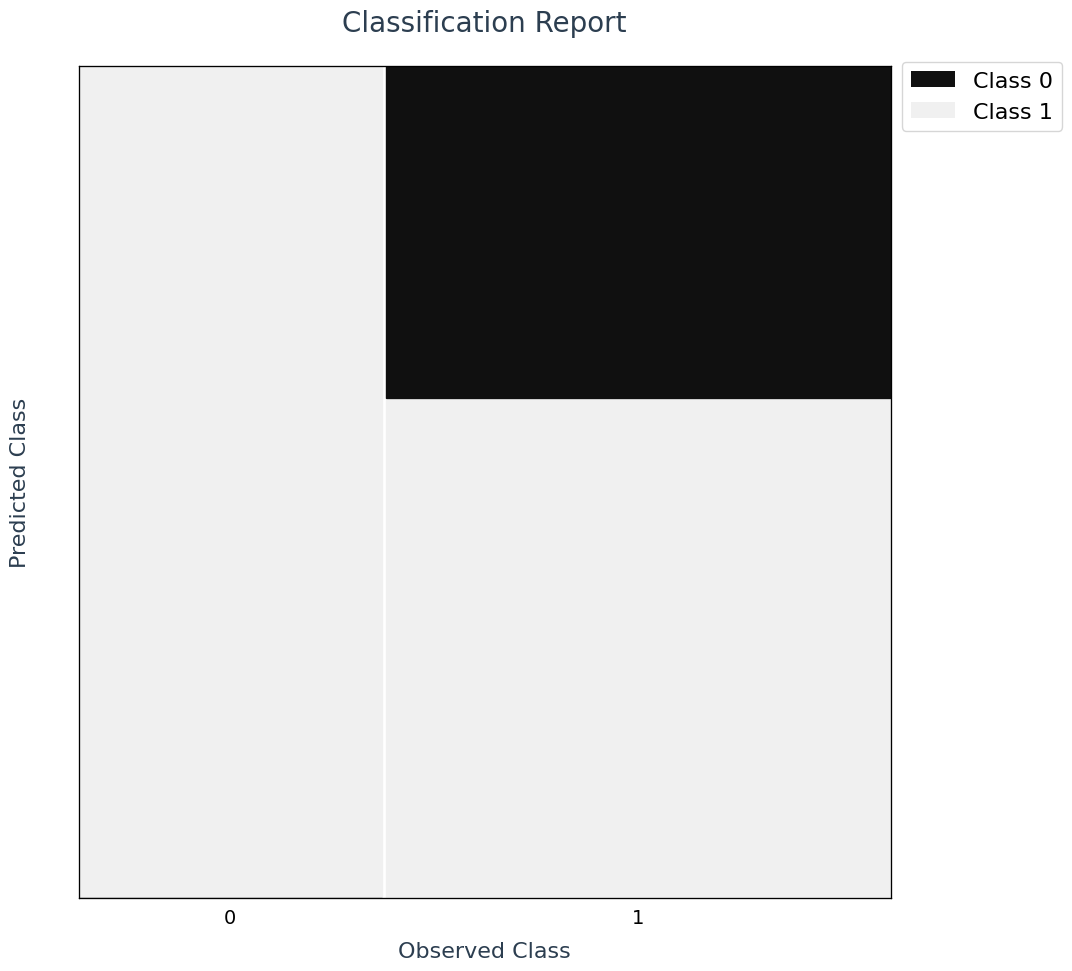

In [ ]:
report.mosaic_plot()

In [ ]:
report.print_AUC()

Clas_0: 0.5333333333333333
Clas_1: 0.5333333333333333


In [ ]:
print("CROSS ENTROPY:",report.cross_entropy())
print("Accuracy:",report.accuracy())

CROSS ENTROPY: 1.0320244199449256
Accuracy: 0.375


# TESTING OUR PERFORMANCE

In [ ]:
device='cpu'
net = NN(model=models.resnet18(pretrained=True),
         cut=1,
         add=Sequential(Sequential(Linear(512,100),ReLU(),Linear(100,2)),Softmax(dim=1)),
         gradients=10)
net=net.to(device)
net.load()

c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
e:\Thesis\DL\Image Conversion\SuperTML\NN.py:177: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://gi

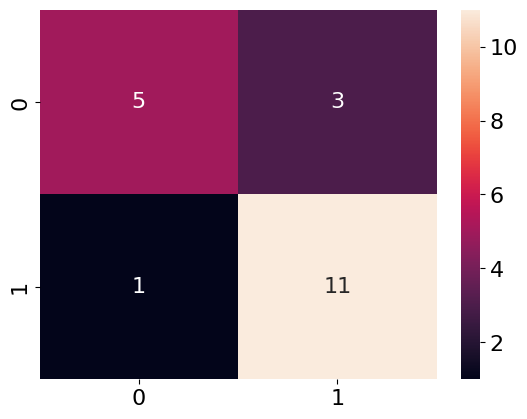

In [ ]:
report=ClassificationReport(net)
report.fit(X_test,Y_test)
report.heatmap()

In [ ]:
report.print_AUC()

Clas_0: 0.75
Clas_1: 0.75


In [ ]:
print("CROSS ENTROPY:",report.cross_entropy())
print("Accuracy:",report.accuracy())

CROSS ENTROPY: 0.6340068226257857
Accuracy: 0.8
